In [1]:
from DELCgen import *
import scipy.stats as st
import matplotlib.pyplot as plt 
from constants import *
from scipy.interpolate import interp1d
import naima
import astropy.units as u
import subroutines as sub
import os
import time

This piece of code runs a simple simulation where a CR population is injected and evolved with a variable jet. We need to define the maximum rigidity which is related to the jet power
$$
R_{\mathrm{max}} = 10^{19}~V\left(\frac{Q_j}{10^{44}~\mathrm{erg~s}^{-1}}\right)^{1/2}
    \left(\frac{\eta}{0.1}\right)
    \left(\frac{u}{0.1c}\right).
$$

the "power threshold" is the inverse expression with $Q_j$ as the subject. We use an input power spectral density (PSD) and jet power probability distribution function (PDF) to generate a time series for the jet power for a given set of PSD and PDF parameters. To do this, we use the method described by Emmanolopoulous et al. and implemented in python by Connolly. The PSD is implemented as a bending power-law model of the form 

$$\mathrm{PSD}(\nu,\bar{Q},\nu_c) = A(\bar{Q}) \frac{\nu^{-\alpha_{\mathrm{low}}}}
               {1+(\nu/\nu_c)^{\alpha_{\mathrm{high}}-\alpha_{\mathrm{low}}}}$$
               
               
We set $\alpha_{\mathrm{low}} = 1$ for a pink noise spectrum, $\alpha_{\mathrm{high}} = 10$ so as to suppress high frequency variability, and $\nu_c = 1$Myr, roughly equal to the light travel time, $\tau_c=L/c$, along a $L=300$kpc jet. The acceleration time relates to $\tau_c$ by $\tau_\mathrm{acc}/\tau_c \approx (Rc)/(uL)$, since the highest energy particles reach Larmor radii comparable to $(u/c)R$ (Hillas criterion). The longest CR acceleration time is therefore shorter than the light travel time along the jet for any fast, long and thin jet ($u/c>R/L$). 

In [2]:
def power_threshold(rigidity, v_over_c=0.1, eta=0.1):
    power = (0.1 / eta) * (rigidity / 1e19)**2 * (0.1/v_over_c) * 1e44
    return power 

def max_energy(power, v_over_c=0.1, eta=0.1):
    return 1e19*np.sqrt( (power/1e44) * (v_over_c/0.1))

def get_lc(lognorm_params, PSD_params, tbin, Age):
    # Simulation params
    # let's do everything in units of kyr
    # run for 100 Myr (1e5 kyr) in bins of 0.1 Myr
    #lognorm_params = (1.5,0,np.exp(1.5))
    RedNoiseL,RandomSeed,aliasTbin = 100,12,100
    N = Age / tbin

    lc = Simulate_DE_Lightcurve(BendingPL, PSD_params,st.lognorm,lognorm_params,
                                    RedNoiseL=RedNoiseL,aliasTbin=aliasTbin,randomSeed=RandomSeed,LClength=Age, tbin=tbin)

    return (lc)

Now we've set up the basic functions. Let's initialise our parameters for the variable jet history and initialise the tau_loss dictionary which stores the loss times for the different species (calculated using CRPropa).  

In [3]:
# since we're in Kyr units, set up conversion
MYR = 1e3

# set up light curve. pl_index of 1 means red noise.
pl_index = 1

# bend the power law at 1 Myr (1e-3 kyr^-1) and steeply decay it beyond that with index 10. 
# A,v_bend,a_low,a_high,c = 1, 1e-3, pl_index, 10, 1
PSD_params = (1, 1.0 * MYR, pl_index, 10, 1)
tbin = 0.1 * MYR   # 100 kyr 
Age = 100.0 * MYR
Length = int(Age / tbin)

# time is in kyr, so convert to Myr
times = np.arange ( 0, Length*tbin, tbin) 

energies = np.logspace(6,20.5,num=3000)
lognorm_params = (1.5,0,np.exp(1.5))
    
# paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
lc = get_lc(lognorm_params, PSD_params, tbin, Length)

Set up arrays to loop over. flux_scales contains the normalisations of our jet power $(\bar{Q})$.
This is actually the median of the distribution, or the mean in log space.
betas is the spectral index of the injected spectrum ($\beta$).

In [4]:
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
#flux_scales = np.logspace(43,45,num=10)
betas = [2,2.3,2.7]
flux_scales = np.logspace(42.5,44.5,num=10)
sigmas = np.linspace(0.5,3,num=10)

0


AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

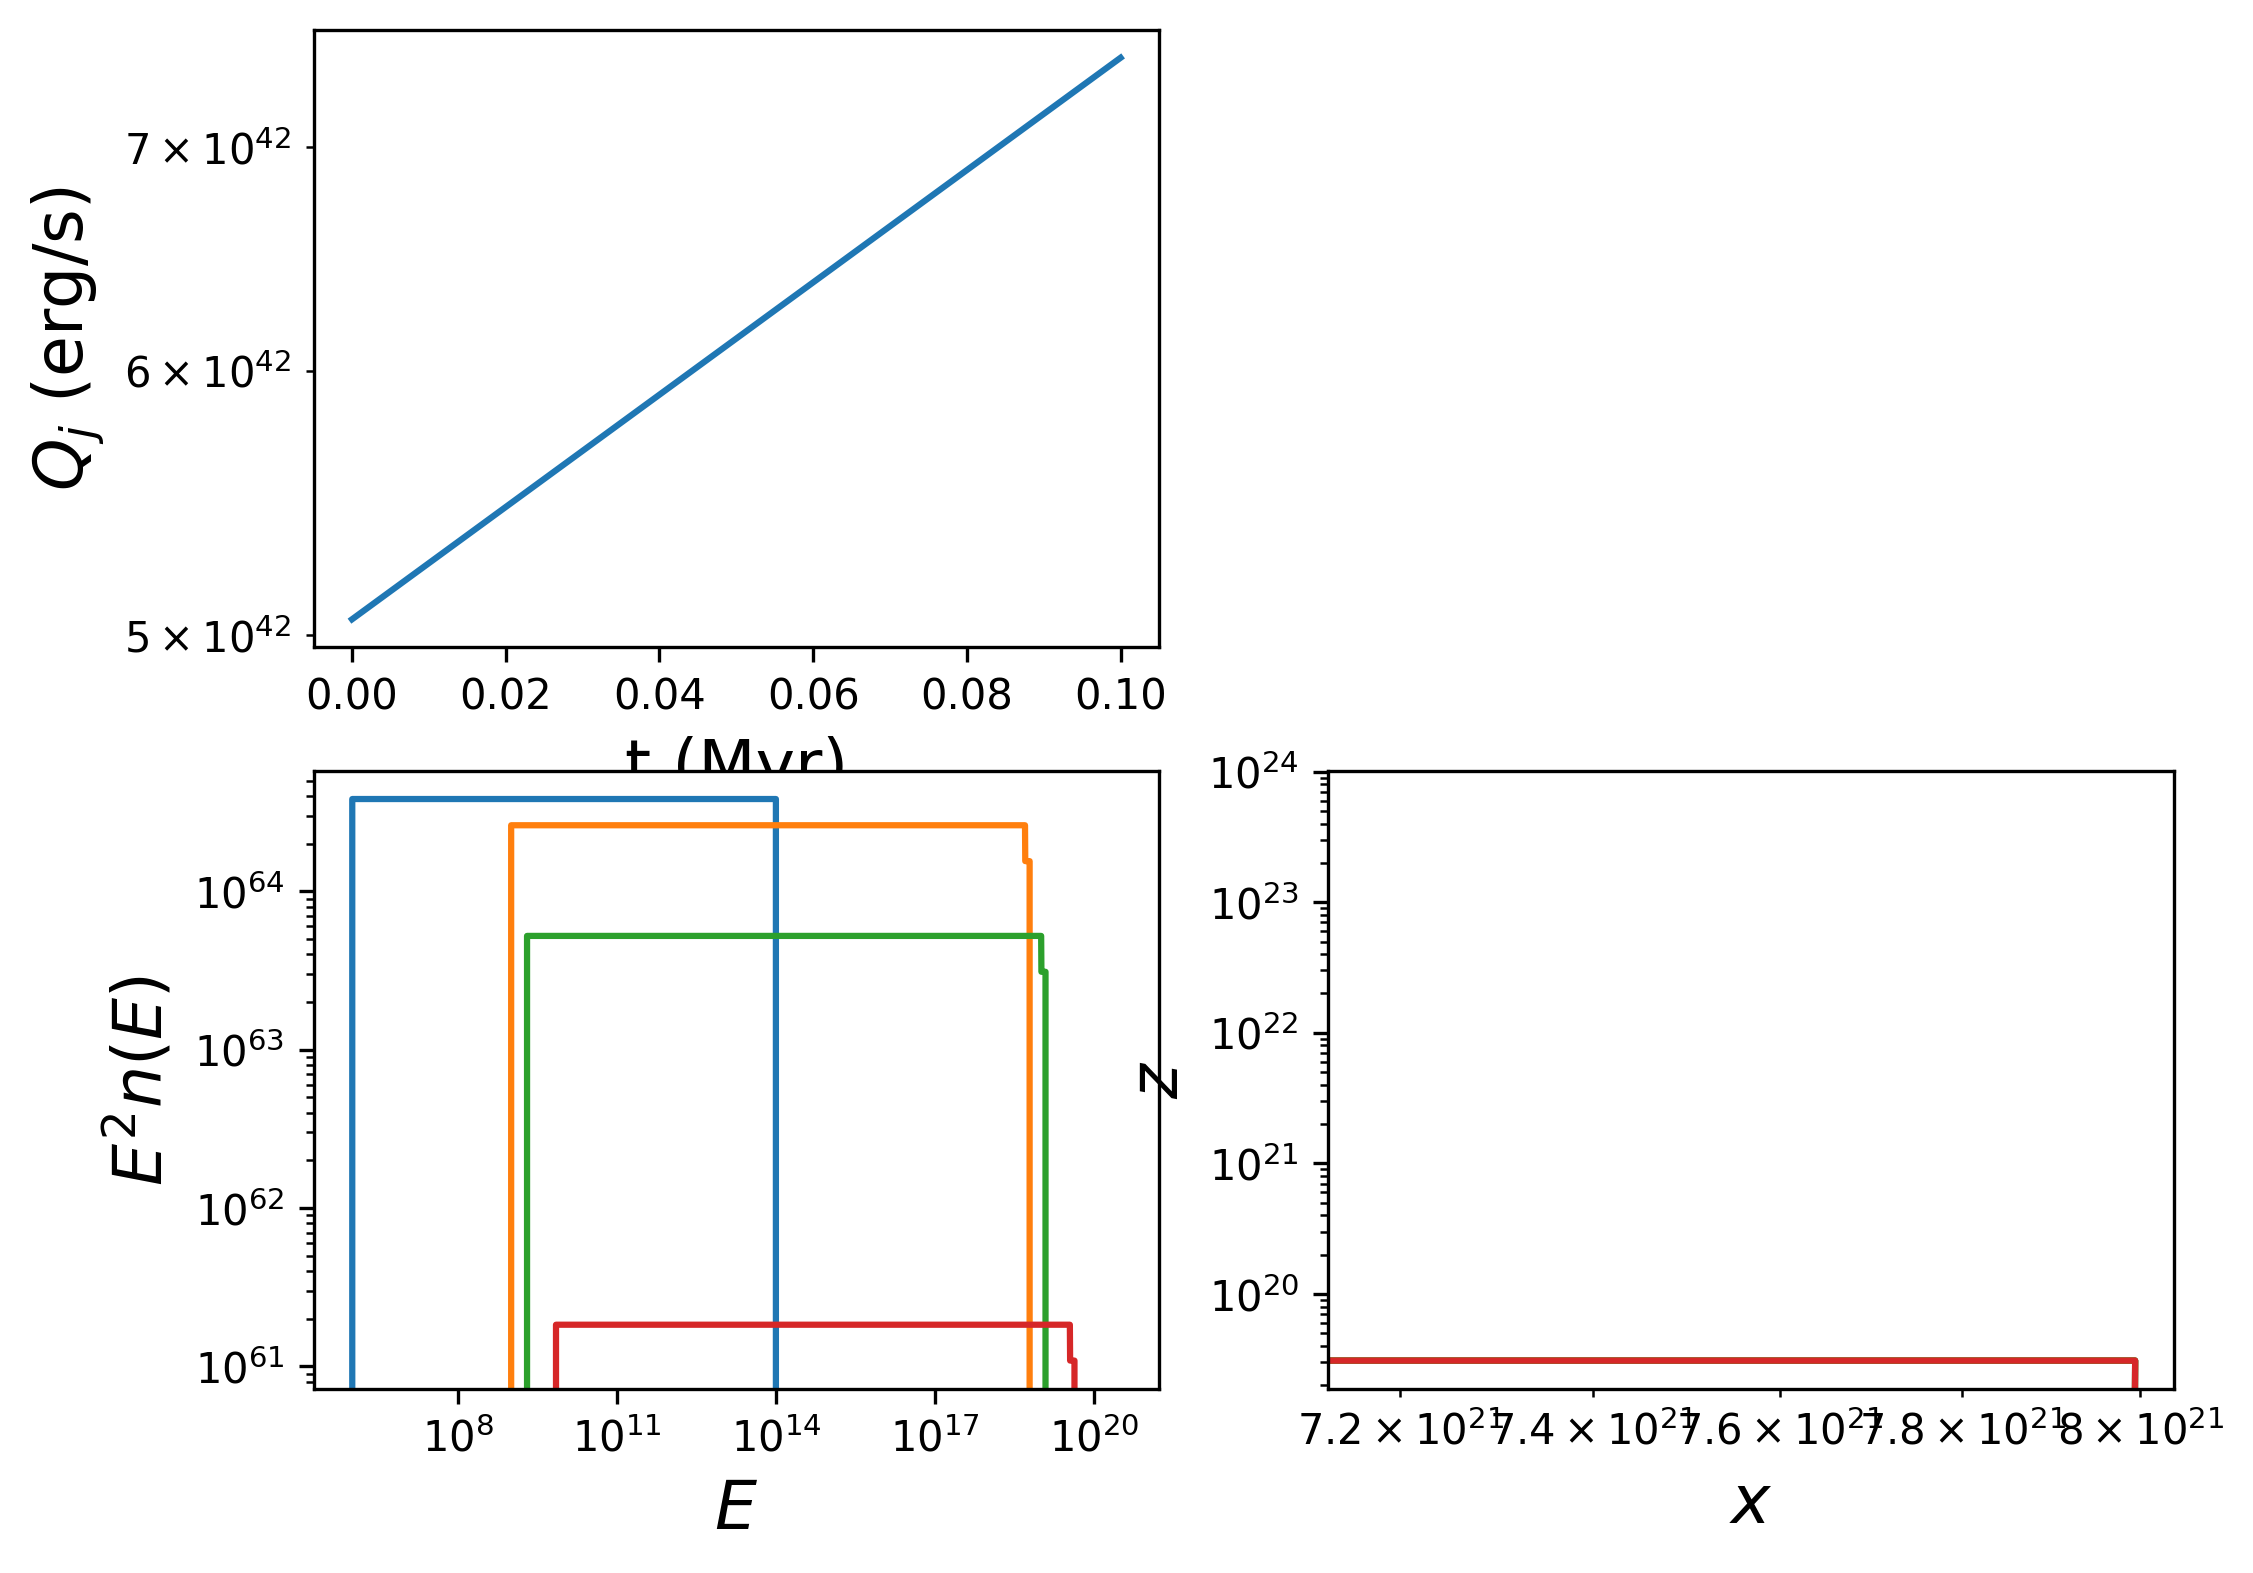

In [10]:
energies = np.logspace(6,20.5,num=3000)
# flux_scales contains the normalisations of our jet power 
# actually the median of the distribution, or the mean in log space.
# betas is the spectral index of the injected spectrum 
betas = [2]
#flux_scales = np.logspace(42.5,44.5,num=10)
flux_scales = flux_scales = np.logspace(42.5,44.5,num=10)
sigmas = np.linspace(0.5,3,num=10)

for i_sigma, SIGMA in enumerate(sigmas):
    
    lognorm_params = (SIGMA,0,np.exp(SIGMA))
    
    # paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
    lc = get_lc(lognorm_params, PSD_params, tbin, Length)
                      
    for i_flux, flux_scale in enumerate(flux_scales):
        # normalise the light curve
        flux = lc.flux * flux_scale 
    
        # loop over spectral indices
        for i_beta, BETA in enumerate(betas):
            
            print (i_beta)

            # initialise figure and movie file name
            fname = "movies/movie_beta{:.1f}q{:.1f}sig{:.1f}".format(BETA, np.log10(flux_scale),  SIGMA)
            p, fig, ax1, ax2, ax3 = sub.init_fig(fname=fname, fmt="mp4", fps=6)

            # load the arrays calculated
            ncr_time = np.load("array_saves/ncr_beta{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale),  SIGMA))
            #import os
            #print (os.getcwd())
            dimensions = np.load("array_saves/dim_{:.1f}q{:.1f}sig{:.1f}.npy".format(BETA, np.log10(flux_scale),  SIGMA))
            
            # get the time step - IMPROVE 
            delta_t = tbin * 1000.0 * YR

            # charges 
            z_elem = np.array([1,2,7,26])

            movie_counter = 0
            DELTA = 2

            for i in range(1,len(flux), DELTA):            
                # this clears axes and plots the lightcurve 
                ax1.clear()
                sub.plot_lc(ax1, lc.time[:i+1] / 1000.0, flux[:i+1])
                ax2.clear()
                ax3.clear()


                for j, frac in enumerate(z_elem):
                    sub.plot_spectra_morph(fig, ax2, ax3, energies, ncr_time[j,i,:], dimensions[:,i,:], j)

                # extract the image as an ARGB string
                string = fig.canvas.tostring_argb()

                # write to pipe
                p.stdin.write(string) 


            print ("BETA {:.1f} median lum {:8.4e} mean lum {:8.4e}".format(BETA, flux_scale, np.mean(flux)))
            # Finish up
            p.communicate()

            print ("{:.2f} seconds".format(time.time() - t1))

In [ ]:
import os
import io
import base64
from IPython.display import HTML

# for i_flux, flux_scale in enumerate(flux_scales):
#     for i_beta, BETA in enumerate(betas):
#         print (flux_scale, BETA)
#         fname = "beta{:.1f}q{:.1f}".format(BETA, np.log10(flux_scale))
#         #cmd = "ffmpeg -y -i spectra/{}/spectra%3d.png -r 6 movies/movie_{}.mp4".format(fname,fname)
#         cmd = "ffmpeg -y -i spectra/{}/spectra%3d.jpg -r 6 movies/movie_{}.gif".format(fname,fname)
#         os.system(cmd)
#         time.sleep(3)
        
# open the last movie?  
moviename = "movies/movie_{}.mp4".format(fname)
video = io.open(moviename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

from IPython.display import Video

Video(moviename )

Now let's make a movie with ffmpeg (pretty hacky this)